Installation and Data Loading

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
# 1. Global settings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_theme(style="whitegrid")

# 2. Data loading (Desktop path)
desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')

try:
    # Reading csv files
    df_trips = pd.read_csv(os.path.join(desktop_path, 'trips_cleaned.csv'))
    df_routes = pd.read_csv(os.path.join(desktop_path, 'routes_cleaned.csv'))
    df_st = pd.read_csv(os.path.join(desktop_path, 'stop_times_cleaned.csv'))

    # Strip whitespaces from column names
    for df in [df_trips, df_routes, df_st]:
        df.columns = df.columns.str.strip()

    # Data preparation for frequency analysis
    df_st_clean = df_st.dropna(subset=['departure_time_sec']).copy()
    df_st_clean['hour'] = (df_st_clean['departure_time_sec'] // 3600).astype(int)
    df_master = pd.merge(df_trips, df_routes, on='route_id', how='left')

    # Data preparation for duration analysis
    trip_durations = df_st.groupby('trip_id')['arrival_time_sec'].agg(['max', 'min'])
    trip_durations['total_sec'] = trip_durations['max'] - trip_durations['min']
    df_dur_merge = pd.merge(trip_durations.reset_index(), df_trips[['trip_id', 'route_id']], on='trip_id')
    df_final_named = pd.merge(df_dur_merge, df_routes[['route_id', 'route_short_name', 'route_long_name']], on='route_id')
    df_final_named['avg_min'] = df_final_named['total_sec'] / 60
    hat_sureleri = df_final_named.groupby(['route_short_name', 'route_long_name'])['avg_min'].mean().sort_values(ascending=False).head(10)

    print("Data loaded and merged successfully")
    
    # Summary statistics
    print("\n" + "="*50)
    print("ISTANBUL TRANSPORTATION ANALYSIS SUMMARY")
    print("="*50)
    print(f"Total Unique Routes  : {df_routes['route_id'].nunique()}")
    print(f"Total Daily Trips    : {df_trips['trip_id'].nunique()}")
    print("="*50)

except Exception as e:
    print(f"❌ Error occurred during data loading: {e}")

Data loaded and merged successfully

ISTANBUL TRANSPORTATION ANALYSIS SUMMARY
Total Unique Routes  : 8017
Total Daily Trips    : 133121


Main Dashboard

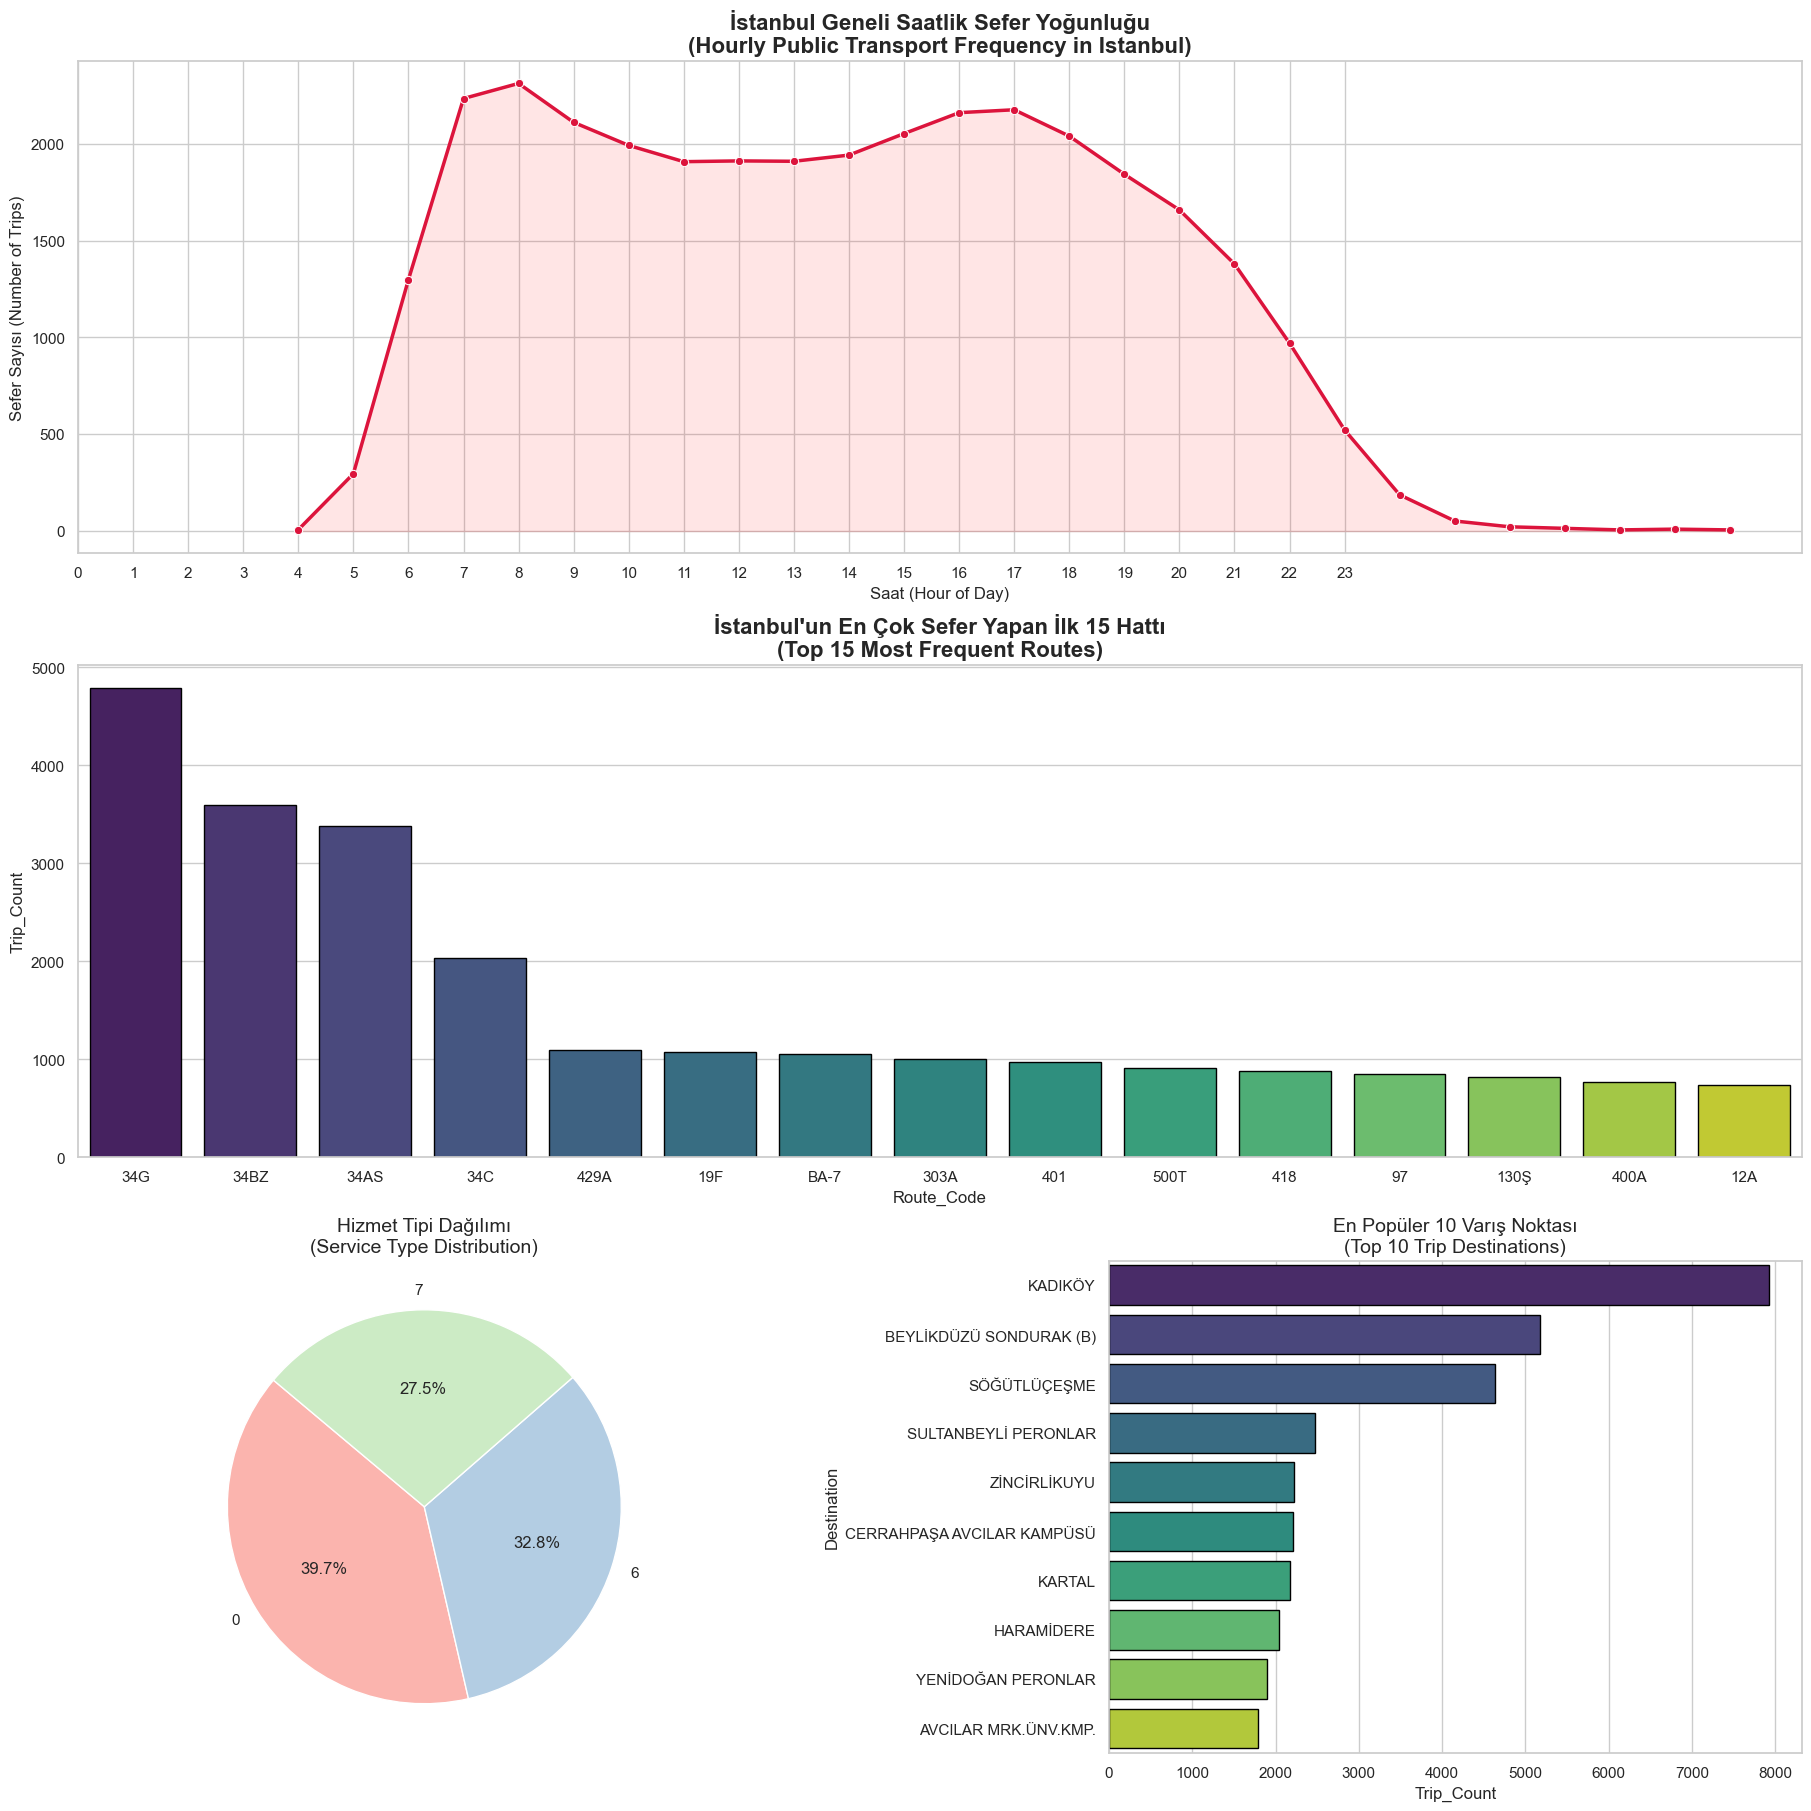

In [4]:
# Create dashboard for frequency and distribution
plt.rcParams['figure.figsize'] = [18, 18]
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 2)

# Chart 1: Hourly trip frequency
ax1 = fig.add_subplot(gs[0, :])
hourly_counts = df_st_clean.groupby('hour')['trip_id'].nunique()
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', color='crimson', linewidth=2.5, ax=ax1)
ax1.fill_between(hourly_counts.index, hourly_counts.values, color='red', alpha=0.1)
ax1.set_title('İstanbul Geneli Saatlik Sefer Yoğunluğu\n(Hourly Public Transport Frequency in Istanbul)', fontsize=16, fontweight='bold')
ax1.set_xticks(range(0, 24))
ax1.set_xlabel('Saat (Hour of Day)')
ax1.set_ylabel('Sefer Sayısı (Number of Trips)')

# Chart 2: Top 15 frequent routes
ax2 = fig.add_subplot(gs[1, :])
top_15_routes = df_master['route_short_name'].value_counts().head(15).reset_index()
top_15_routes.columns = ['Route_Code', 'Trip_Count']
sns.barplot(data=top_15_routes, x='Route_Code', y='Trip_Count', palette='viridis', edgecolor='black', ax=ax2)
ax2.set_title("İstanbul'un En Çok Sefer Yapan İlk 15 Hattı\n(Top 15 Most Frequent Routes)", fontsize=16, fontweight='bold')

# Chart 3: Service type distribution
ax3 = fig.add_subplot(gs[2, 0])
service_counts = df_trips['service_id'].value_counts()
ax3.pie(service_counts, labels=service_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Pastel1'), startangle=140)
ax3.set_title('Hizmet Tipi Dağılımı\n(Service Type Distribution)', fontsize=14)

# Chart 4: Top 10 destinations
ax4 = fig.add_subplot(gs[2, 1])
top_dest = df_trips['trip_headsign'].value_counts().head(10).reset_index()
top_dest.columns = ['Destination', 'Trip_Count']
sns.barplot(data=top_dest, x='Trip_Count', y='Destination', palette='viridis', edgecolor='black', ax=ax4)
ax4.set_title('En Popüler 10 Varış Noktası\n(Top 10 Trip Destinations)', fontsize=14)

plt.show()

Journey Time Analysis (Longest Routes)

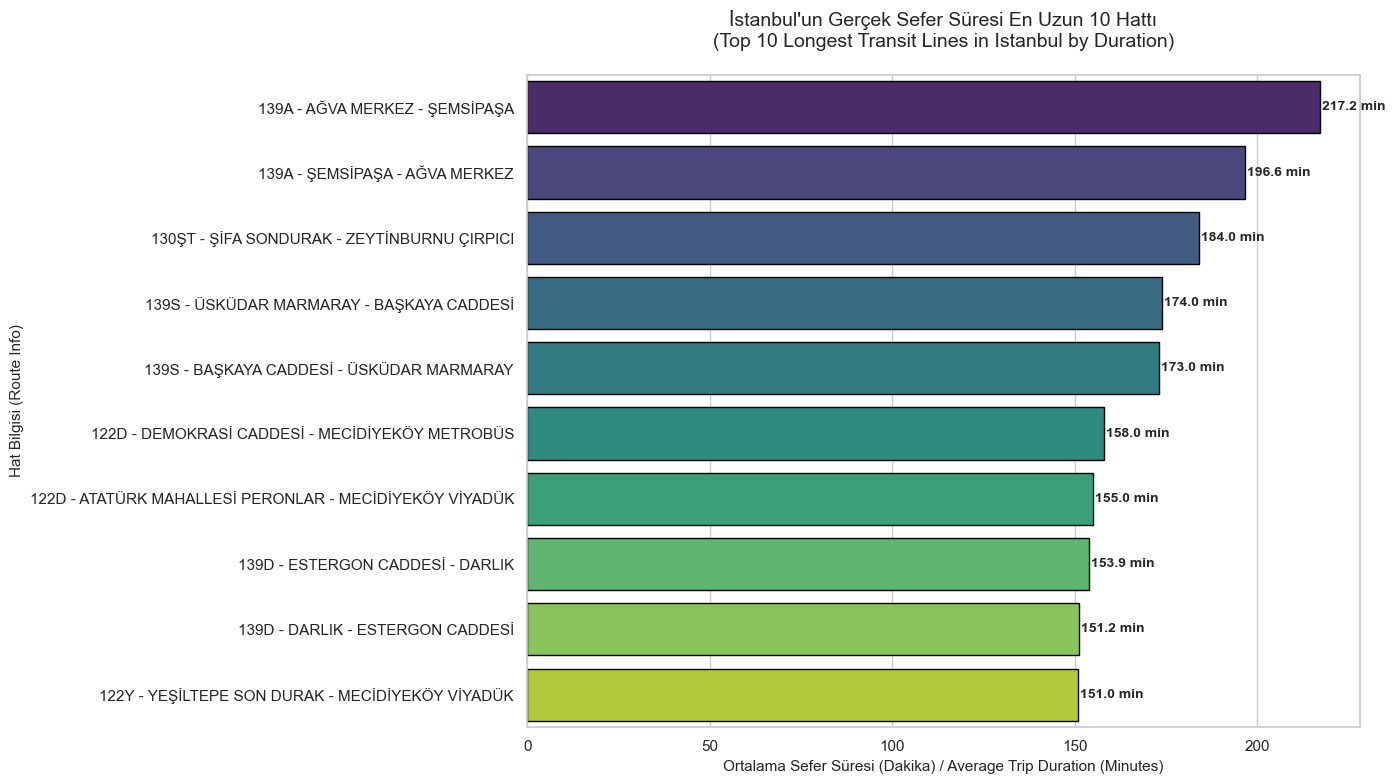

In [5]:
# Separate plot for the longest lines duration
plt.figure(figsize=(14, 8))

# Data preparation for duration chart
plot_df = hat_sureleri.reset_index()
plot_df['hat_tam_ad'] = plot_df['route_short_name'] + " - " + plot_df['route_long_name']

# Create the bar plot
barplot = sns.barplot(data=plot_df, x='avg_min', y='hat_tam_ad', palette='viridis', edgecolor='black')

# Add values to the end of the bars
for i, value in enumerate(plot_df['avg_min']):
    barplot.text(value + 0.5, i, f'{value:.1f} min', va='center', fontsize=10, fontweight='bold')

# Labels and Titles
plt.title("İstanbul'un Gerçek Sefer Süresi En Uzun 10 Hattı\n(Top 10 Longest Transit Lines in Istanbul by Duration)", fontsize=14, pad=20)
plt.xlabel("Ortalama Sefer Süresi (Dakika) / Average Trip Duration (Minutes)", fontsize=11)
plt.ylabel("Hat Bilgisi (Route Info)", fontsize=11)

plt.tight_layout()
plt.show()

Project Conclusion & Insights

Throughout this analysis of Istanbul's public transportation data (GTFS), several key findings have emerged:

*   Peak Performance: 
The hourly distribution confirms that Istanbul’s transit network hits its maximum capacity 
between 07:00-09:00 and 17:00-19:00, correlating with peak commuting hours.
    
*   High-Frequency Arteries:
The "Top 15 Routes" chart identifies the backbone of the city's mobility, where fleet management is most critical.

*   Operational Challenges: 
The "Longest Duration" analysis highlights routes that exceed 100+ minutes, 
signaling areas where traffic congestion orlong-distance travel significantly impacts service reliability.
*   Service Balance: 
The distribution between weekday and weekend services shows a high optimization for the city's working population.    
